# Steps
1. Import Training csv
2. Drop benign data
3. Setup autogluon
4. Train non persistent model
5. Test non persistent model
6. Check leaderboard
7. Check feature importance

# Imports 

In [37]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt

# Import Training data

In [3]:

train_df = pd.read_csv("cic_ids_2017_train.csv")


In [4]:
train_df

,src_port,dst_port,src2dst_packets,dst2src_packets,src2dst_bytes,dst2src_bytes,src2dst_duration_ms,dst2src_duration_ms,src2dst_rst_packets,dst2src_rst_packets,...,bidirectional_psh_packets,bidirectional_ack_packets,bidirectional_urg_packets,bidirectional_cwr_packets,bidirectional_ece_packets,src2dst_psh_packets,dst2src_psh_packets,src2dst_urg_packets,dst2src_urg_packets,Label
0,53586,80,3,1,0,0,501,0,1,0,...,0,3,0,0,0,0,0,0,0,Portscan
1,60406,53,2,2,99,161,85374731,85375381,0,0,...,0,0,0,0,0,0,0,0,0,BENIGN
2,58864,80,8,6,414,11595,161992,149636,1,0,...,2,13,0,0,0,1,1,0,0,DoS Hulk
3,52186,21,11,17,108,188,10209325,10209249,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator
4,56298,80,8,6,704,11595,371974,360760,2,0,...,3,11,0,0,0,2,1,0,0,DoS Hulk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34595,53674,21,11,17,128,188,9290170,9290144,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator
34596,58198,80,14,3,2541,0,102642586,102642661,0,1,...,11,15,0,0,0,11,0,0,0,DoS Slowloris
34597,60731,53,1,1,80,208,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BENIGN
34598,59624,21,11,17,116,188,8919913,8919859,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator


# Drop Unused Labels

In [5]:
# postscan overlaps with recon in persistent dataset, DDoS dont have a good way to test, botnet small dataset not good way to test.
unused = ['Infiltration - Portscan', 'Portscan', 'DDoS', 'Botnet']

train_df = train_df.loc[~train_df['Label'].isin(unused)]

<Axes: >

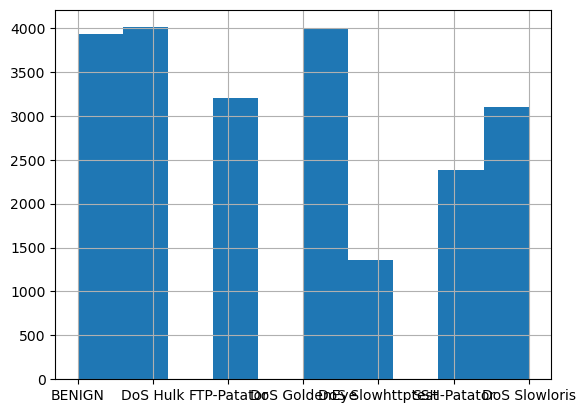

In [6]:
train_df['Label'].hist()

In [7]:
train_df['Label'].unique()

array(['BENIGN', 'DoS Hulk', 'FTP-Patator', 'DoS GoldenEye',
       'DoS Slowhttptest', 'SSH-Patator', 'DoS Slowloris'], dtype=object)

# Drop the benign data

In [8]:
non_benign_mask = train_df['Label'] != "BENIGN"
train_df = train_df[non_benign_mask]
train_df['Label'].unique()

array(['DoS Hulk', 'FTP-Patator', 'DoS GoldenEye', 'DoS Slowhttptest',
       'SSH-Patator', 'DoS Slowloris'], dtype=object)

In [9]:
testbed_training = pd.read_csv('testbed_training.csv')

<Axes: >

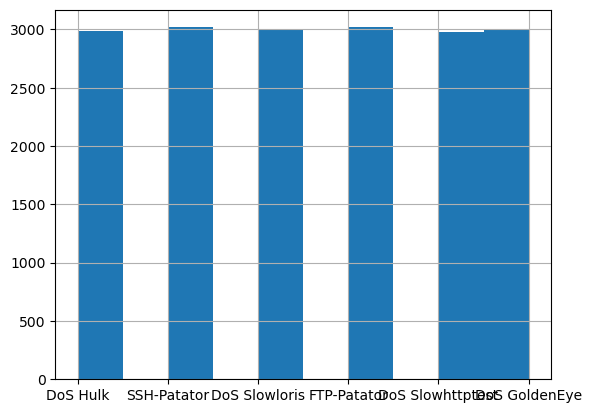

In [10]:
testbed_training['Label'].hist()

In [11]:
testbed_training['Label'].unique()

array(['DoS Hulk', 'SSH-Patator', 'DoS Slowloris', 'FTP-Patator',
       'DoS Slowhttptest', 'DoS GoldenEye'], dtype=object)

# Import test data and check leaderboard on testing data

<Axes: >

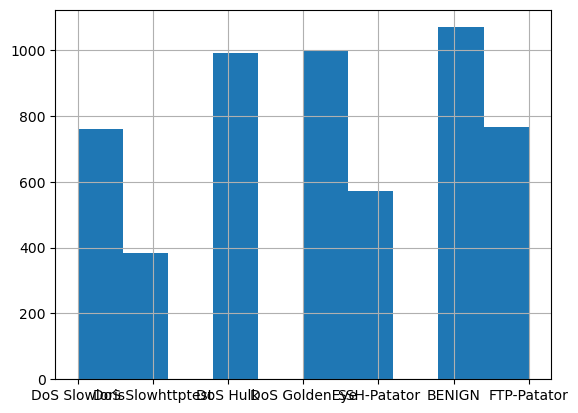

In [12]:
test_df = pd.read_csv('cic_ids_2017_test.csv')

# postscan overlaps with recon in persistent dataset, DDoS dont have a good way to test, botnet small dataset not good way to test.
unused = ['Infiltration - Portscan', 'Portscan', 'DDoS', 'Botnet']

test_df = test_df.loc[~test_df['Label'].isin(unused)]
test_df['Label'].hist()

# Remove benign data from test

In [13]:
non_benign_mask = test_df['Label'] != "BENIGN"
test_df = test_df[non_benign_mask]
test_df['Label'].unique()

array(['DoS Slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'SSH-Patator', 'FTP-Patator'], dtype=object)

# Testbed data test data

In [14]:
testbed_testing = pd.read_csv('testbed_testing.csv')
testbed_testing = testbed_testing.loc[testbed_testing['Label'] != 'BENIGN']
testbed_testing['Label'].unique()

array(['DoS GoldenEye', 'FTP-Patator', 'DoS Slowloris',
       'DoS Slowhttptest', 'SSH-Patator', 'DoS Hulk'], dtype=object)

# Shuffle training data

In [40]:
train_df = train_df.sample(frac=1, random_state=29)
testbed_training = testbed_training.sample(frac=1, random_state=29)

# How much CIC IDS data is needed to train an accurate model?

In [45]:
stats = pd.DataFrame(columns=['train_rows', 'mcc', 'accuracy', 'balanced_accuracy', 'testbed_accuracy', 'best_model'])
for train_rows in range(2000, 18000, 2000):
    print(train_rows)
    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=train_df[:train_rows], fit_weighted_ensemble=False)
    evaluation = predictor.evaluate(test_df)
    leaderboard = predictor.leaderboard(test_df)

    evaluation_testbed = predictor.evaluate(testbed_testing)

    new_row = {'mcc': evaluation['mcc'], 'accuracy':evaluation['accuracy'], 'train_rows':train_rows, 'balanced_accuracy': evaluation['balanced_accuracy'], 'best_model': leaderboard.iloc[0]['model'], 'testbed_accuracy': evaluation_testbed['accuracy']}
    stats.loc[len(stats)] = new_row
    print(stats)

No path specified. Models will be saved in: "AutogluonModels\ag-20250703_053258"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       41.99 GB / 63.72 GB (65.9%)
Disk Space Avail:   742.98 GB / 1906.98 GB (39.0%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250703_053258"
Train Data Rows:    2000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	6 unique label values:  ['FTP-Patator', 'DoS Hulk', 'DoS Slowloris', 'DoS Slowhttptest', 'SSH-Patator', 'DoS GoldenEye']
	If 'multiclass' is not the correct 

2000


	1.0	 = Validation score   (mcc)
	1.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.997	 = Validation score   (mcc)
	0.95s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.997	 = Validation score   (mcc)
	1.02s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.997	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.997	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.997	 = Validation score   (mcc)
	9.47s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.997	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.997	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	0.997	 

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   

         best_model  
0  RandomForestEntr  
4000


	0.9976	 = Validation score   (mcc)
	1.98s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9951	 = Validation score   (mcc)
	1.08s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.12s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9976	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9976	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9951	 = Validation score   (mcc)
	2.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9976	 = Validation score   (mcc)
	0.43s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9976	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...


   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
6000


	1.0	 = Validation score   (mcc)
	3.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.11s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.16s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	87.93s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	1.0	 = Validation 

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
8000


	1.0	 = Validation score   (mcc)
	4.39s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.31s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	0.9985	 = Validation score   (mcc)
	1.43s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	91.95s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9985	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9985	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	1.0	 = Vali

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   
3        8000  0.999454  0.999552           0.999397          0.278333   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
3    ExtraTreesEntr  
10000


No improvement since epoch 5: early stopping
	0.9988	 = Validation score   (mcc)
	4.39s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9988	 = Validation score   (mcc)
	1.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	0.9988	 = Validation score   (mcc)
	1.23s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9988	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9988	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9988	 = Validation score   (mcc)
	7.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9988	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9988	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   
3        8000  0.999454  0.999552           0.999397          0.278333   
4       10000  0.996725  0.997315           0.995980          0.397167   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
3    ExtraTreesEntr  
4  RandomForestEntr  
12000


Metric mcc is not supported by this model - using log_loss instead
	1.0	 = Validation score   (mcc)
	6.04s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.2s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.27s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	98.36s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 =

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   
3        8000  0.999454  0.999552           0.999397          0.278333   
4       10000  0.996725  0.997315           0.995980          0.397167   
5       12000  0.996727  0.997315           0.995497          0.378500   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
3    ExtraTreesEntr  
4  RandomForestEntr  
5   NeuralNetFastAI  
14000


	0.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	1.0	 = Validation score   (mcc)
	7.37s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.36s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.38s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.62s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.61s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	107.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.55s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting mo

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   
3        8000  0.999454  0.999552           0.999397          0.278333   
4       10000  0.996725  0.997315           0.995980          0.397167   
5       12000  0.996727  0.997315           0.995497          0.378500   
6       14000  0.999181  0.999329           0.998695          0.290667   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
3    ExtraTreesEntr  
4  RandomForestEntr  
5   NeuralNetFastAI  
6  RandomForestEntr  
16000


	0.01s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	1.0	 = Validation score   (mcc)
	8.31s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.27s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.65s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	109.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting mod

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.994543  0.995525           0.994779          0.128333   
1        4000  0.998635  0.998881           0.998091          0.378833   
2        6000  0.998907  0.999105           0.998528          0.336667   
3        8000  0.999454  0.999552           0.999397          0.278333   
4       10000  0.996725  0.997315           0.995980          0.397167   
5       12000  0.996727  0.997315           0.995497          0.378500   
6       14000  0.999181  0.999329           0.998695          0.290667   
7       16000  0.999454  0.999552           0.999398          0.272333   

         best_model  
0  RandomForestEntr  
1    ExtraTreesEntr  
2    ExtraTreesGini  
3    ExtraTreesEntr  
4  RandomForestEntr  
5   NeuralNetFastAI  
6  RandomForestEntr  
7    ExtraTreesEntr  


<Axes: xlabel='train_rows', ylabel='value'>

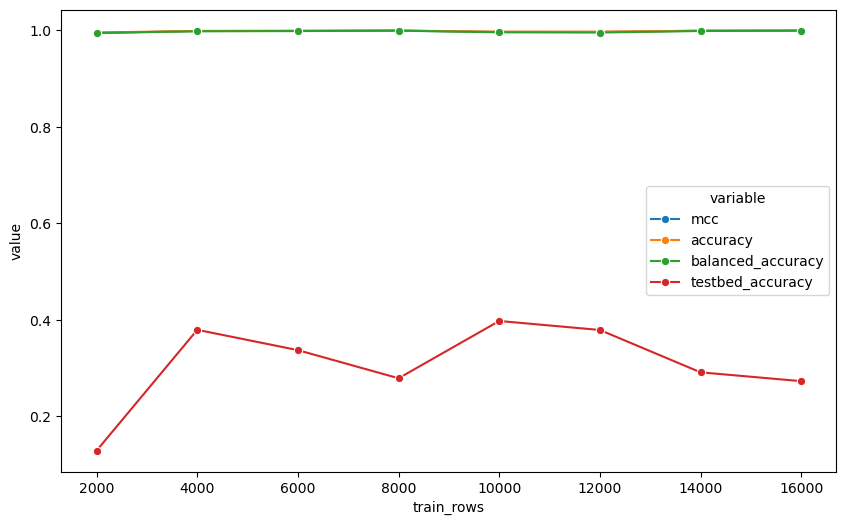

In [46]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = stats.melt(id_vars='train_rows',
                          value_vars=['mcc', 'accuracy', 'balanced_accuracy', 'testbed_accuracy'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='train_rows', y='value', hue='variable', marker='o')

Autogluon trains a very accurate model for cic-ids dataset with very few rows. However, validating the model against out testbed data shows poor results. Interestingly, we see at train_rows 4000, we get a spike in the accuracy for the testbed validation data. We will use 4000 rows as the baseline amount of cic-ids data used.

In [48]:
stats = pd.DataFrame(columns=['train_rows', 'mcc_cic_ids', 'mcc_testbed', 'mcc_combined', 'best_model_combined'])
for train_rows in range(500, 4500, 500):
    merged_training_df = pd.concat([train_df[:4000], testbed_training[train_df.columns][:train_rows]])
    print(train_rows)
    print(len(merged_training_df))
    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=merged_training_df, fit_weighted_ensemble=False)
    
    evaluation_cic_ids = predictor.evaluate(test_df)
    evaluation_testbed = predictor.evaluate(testbed_testing)


    combined_leaderboard = predictor.leaderboard(pd.concat([testbed_testing, test_df]))
    combined_evaluation = predictor.evaluate(pd.concat([testbed_testing, test_df]))

    new_row = {'train_rows': train_rows, 'mcc_cic_ids':evaluation_cic_ids['mcc'], 'mcc_testbed':evaluation_testbed['mcc'], 'mcc_combined': combined_evaluation['mcc'], 'best_model_combined': combined_leaderboard.iloc[0]['model']}
    stats.loc[len(stats)] = new_row
    print(stats)

No path specified. Models will be saved in: "AutogluonModels\ag-20250703_061755"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       41.66 GB / 63.72 GB (65.4%)
Disk Space Avail:   741.75 GB / 1906.98 GB (38.9%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250703_061755"
Train Data Rows:    4500
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	6 unique label values:  ['FTP-Patator', 'DoS Hulk', 'DoS Slowloris', 'DoS Slowhttptest', 'SSH-Patator', 'DoS GoldenEye']
	If 'multiclass' is not the correct 

500
4500


	0.9927	 = Validation score   (mcc)
	2.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9951	 = Validation score   (mcc)
	1.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9951	 = Validation score   (mcc)
	1.24s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9976	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9976	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	0.9927	 = Validation score   (mcc)
	10.95s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9951	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9976	 = Validation score   (mcc)
	0.55s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost .

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1000
5000


	0.9976	 = Validation score   (mcc)
	2.69s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.42s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	0.9976	 = Validation score   (mcc)
	97.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9976	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	0.9951	 = 

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
1500
5500


No improvement since epoch 1: early stopping
	0.9185	 = Validation score   (mcc)
	2.33s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9956	 = Validation score   (mcc)
	1.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9934	 = Validation score   (mcc)
	1.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9934	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9934	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.989	 = Validation score   (mcc)
	16.13s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9934	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9934	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 =

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
2000
6000


	0.998	 = Validation score   (mcc)
	3.26s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.998	 = Validation score   (mcc)
	1.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	0.996	 = Validation score   (mcc)
	1.91s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.994	 = Validation score   (mcc)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.994	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.996	 = Validation score   (mcc)
	27.67s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.994	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.996	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	0.99

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
3        2000     0.998635     0.962650      0.977939            LightGBM
2500
6500


	0.9889	 = Validation score   (mcc)
	3.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9944	 = Validation score   (mcc)
	1.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	0.9889	 = Validation score   (mcc)
	1.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9944	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9907	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9907	 = Validation score   (mcc)
	34.1s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9926	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9944	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ..

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
3        2000     0.998635     0.962650      0.977939            LightGBM
4        2500     0.999180     0.965233      0.979659            LightGBM
3000
7000


	0.9914	 = Validation score   (mcc)
	3.58s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9897	 = Validation score   (mcc)
	1.53s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9845	 = Validation score   (mcc)
	1.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9862	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9862	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9845	 = Validation score   (mcc)
	12.47s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9862	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9845	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost 

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
3        2000     0.998635     0.962650      0.977939            LightGBM
4        2500     0.999180     0.965233      0.979659            LightGBM
5        3000     0.998634     0.961273      0.977146            LightGBM
3500
7500


	0.9871	 = Validation score   (mcc)
	3.9s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9936	 = Validation score   (mcc)
	1.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	0.992	 = Validation score   (mcc)
	1.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9887	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9887	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	0.9887	 = Validation score   (mcc)
	14.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9904	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9904	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ..

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
3        2000     0.998635     0.962650      0.977939            LightGBM
4        2500     0.999180     0.965233      0.979659            LightGBM
5        3000     0.998634     0.961273      0.977146            LightGBM
6        3500     0.999727     0.965852      0.980243          LightGBMXT
4000
8000


	0.991	 = Validation score   (mcc)
	4.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9895	 = Validation score   (mcc)
	1.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9895	 = Validation score   (mcc)
	1.57s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9819	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9819	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9865	 = Validation score   (mcc)
	8.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9834	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9819	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost .

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.998362     0.906839      0.945748            CatBoost
1        1000     0.996725     0.920057      0.952601            CatBoost
2        1500     0.999181     0.963239      0.978512            CatBoost
3        2000     0.998635     0.962650      0.977939            LightGBM
4        2500     0.999180     0.965233      0.979659            LightGBM
5        3000     0.998634     0.961273      0.977146            LightGBM
6        3500     0.999727     0.965852      0.980243          LightGBMXT
7        4000     0.998361     0.965847      0.979666            CatBoost


<Axes: xlabel='train_rows', ylabel='value'>

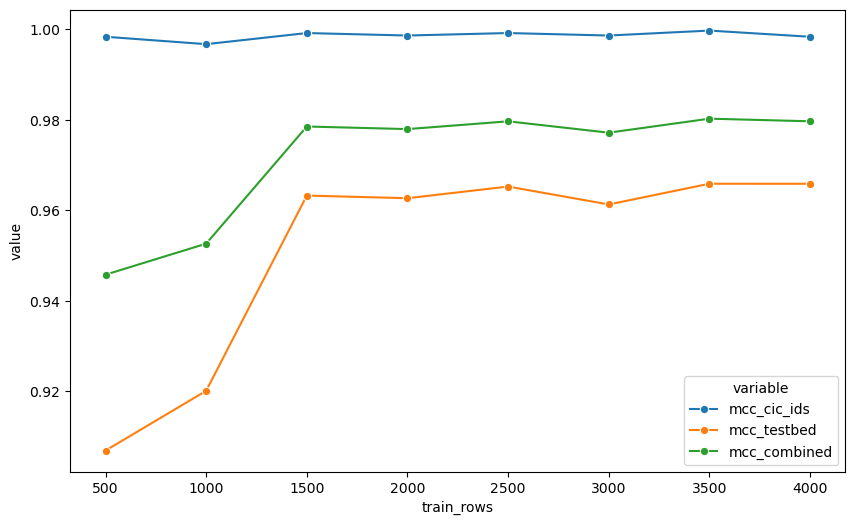

In [49]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = stats.melt(id_vars='train_rows',
                          value_vars=['mcc_cic_ids', 'mcc_testbed', 'mcc_combined'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='train_rows', y='value', hue='variable', marker='o')

Only 1500 rows of testbed data needed to finetune the model. Testbed accuracy goes from from 40% -> 96%

In [50]:
stats

,train_rows,mcc_cic_ids,mcc_testbed,mcc_combined,best_model_combined
0,500,0.998362,0.906839,0.945748,CatBoost
1,1000,0.996725,0.920057,0.952601,CatBoost
2,1500,0.999181,0.963239,0.978512,CatBoost
3,2000,0.998635,0.962650,0.977939,LightGBM
4,2500,0.999180,0.965233,0.979659,LightGBM
5,3000,0.998634,0.961273,0.977146,LightGBM
6,3500,0.999727,0.965852,0.980243,LightGBMXT
7,4000,0.998361,0.965847,0.979666,CatBoost


In [25]:
predictor.leaderboard(testbed_testing)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.970805,0.996696,mcc,0.025865,0.006003,1.802958,0.025865,0.006003,1.802958,1,True,5
1,LightGBMXT,0.970602,0.996696,mcc,0.024741,0.007507,1.848357,0.024741,0.007507,1.848357,1,True,4
2,CatBoost,0.967802,0.995045,mcc,0.000000,0.005417,2.899647,0.000000,0.005417,2.899647,1,True,8
3,RandomForestEntr,0.961802,0.995595,mcc,0.061850,0.040695,0.646045,0.061850,0.040695,0.646045,1,True,7
4,RandomForestGini,0.961406,0.995595,mcc,0.089304,0.040941,0.635295,0.089304,0.040941,0.635295,1,True,6
5,NeuralNetFastAI,0.961261,0.995595,mcc,0.067297,0.016570,11.701685,0.067297,0.016570,11.701685,1,True,3
6,KNeighborsDist,0.944731,0.986789,mcc,0.032104,0.017157,0.023365,0.032104,0.017157,0.023365,1,True,2
7,KNeighborsUnif,0.915871,0.976352,mcc,0.051374,0.019112,0.019407,0.051374,0.019112,0.019407,1,True,1


In [52]:
merged_training_df = pd.concat([train_df[:4000], testbed_training[train_df.columns][:1500]])
predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=merged_training_df, fit_weighted_ensemble=False)

No path specified. Models will be saved in: "AutogluonModels\ag-20250703_063900"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       41.92 GB / 63.72 GB (65.8%)
Disk Space Avail:   741.32 GB / 1906.98 GB (38.9%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250703_063900"
Train Data Rows:    5500
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	6 unique label values:  ['FTP-Patator', 'DoS Hulk', 'DoS Slowloris', 'DoS Slowhttptest', 'SSH-Patator', 'DoS GoldenEye']
	If 'multiclass' is not the correct 

In [53]:
predictor.evaluate(test_df)

{'mcc': np.float64(0.9991805448024867),
 'accuracy': 0.9993287088834191,
 'balanced_accuracy': np.float64(0.9989614976915829)}

In [54]:
predictor.evaluate(testbed_testing)

{'mcc': np.float64(0.9632390055309508),
 'accuracy': 0.9693333333333334,
 'balanced_accuracy': np.float64(0.9694060105480234)}

In [55]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='non_persistent_model_finetune')

Cloned TabularPredictor located in 'c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250703_063900' to 'non_persistent_model_finetune'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="non_persistent_model_finetune")
Clone: Keeping minimum set of models required to predict with best model 'LightGBMXT'...
Deleting model KNeighborsUnif. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\KNeighborsDist will be removed.
Deleting model NeuralNetFastAI. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\NeuralNetFastAI will be removed.
Deleting model LightGBM. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\LightG

In [38]:
print('daintysquish <3')

daintysquish <3
